# Detection of forest loss in Borneo using K-means Unsupervised Learning #

K-means Unsupervised classification is implemented in this notebook to detect and extract forest cover loss from satellite imagery. Images from the satellite Sentinel-2 are used due to its high resolution and comprehensive spectral bands suitable for vegetation analysis. This data is accessed through the Copernicus browser in the notebook using Google Earth Engine (GEE).

Two regions representing regions from both Malaysia and Indonesia are  evaluated in this study. The first location is Sabah, Malaysia, chosen for its rapid palm oil plantation expansion and coastal forest conversion patterns. The Kinbatangan river which cuts through the Sabah region studied is notable, as its home to the orangutan and proboscis monkey which are both native to the area and are endangered species. The other region is in West Kalimantan, Indonesia, chosen for its inland deforestation hotspots where traditional threshold-based methods often struggle to distinguish between degraded forest, secondary growth, and plantation agriculture. A cross-border analysis can allows us to better understand the differences in deforestation rates across Borneo.

Both regions are roughly 44 x 33 km and represent critical areas of the Borneo biodiversity hotspot, where unsupervised machine learning approaches can provide more nuanced classification of forest disturbance patterns than conventional NDVI thresholding alone. The temporal analysis compares 2020 baseline conditions with 2024 recent imagery to quantify the extent and nature of forest cover change across these transboundary landscapes. In the map of Borneo below, our region of interest in Sabah is coloured red and West Kalimantan in blue.

The flexibility of using GEE allows the user of this notebook the ability to reproduce these results for both regions across different temporal ranges. The size and the location of the study region can also be changed using geographic coordinates.

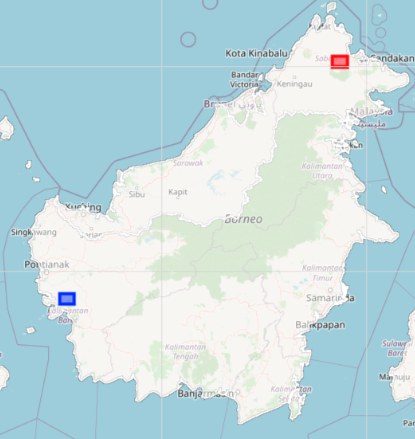

In [ ]:
# Install required packages
#pip install earthengine-api  # Provides 'ee' module
#pip install geemap
#pip install pandas numpy matplotlib seaborn scikit-learn



In [ ]:

import ee
import numpy as np
import geemap
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from IPython.display import Image, display
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')



## Google Earth Engine access

This project accesses the Copernicus browser to extract the images required. This notebook uses Google Earth Engine as a proxy, this was a decision that was made due to some issues downloading the files manually through Copernicus browser.

In order to replicate this analysis in your own Google Eath Engine instance, follow these steps:


1. Register at earthengine.google.com
2. Create a Google Cloud project at console.cloud.google.com
3. Register your Cloud project with Earth Engine (in the Earth Engine Code Editor → Project Manager) then ensure your project is registered for non-commerical use, found under 'Configuration'
4. Replace 'sabah-forest-analysis' with your project ID in the code below
5. Run authentication when prompted

This approach ensures access to the latest satellite data without requiring large file downloads.

**GEE Authentication and initialisation**

In [ ]:
# Trigger the authentication flow.
ee.Authenticate()
ee.Initialize(project='sabah-forest-analysis')


## Image extraction ##

To import the images from Copernicus browser through GEE, we first need to define the  study regions using geographic coordinates. Both regions analysed cover 0.4 degrees longitude by 0.3 degrees latitude.

In [ ]:

study_regions = {
    'sabah_malaysia': {
        'geometry': ee.Geometry.Rectangle([117.2, 5.6, 117.6, 5.9]),
        'country': 'Malaysia',
        'description': 'Coastal Sabah palm oil region'
    },
    'west_kalimantan': {
        'geometry': ee.Geometry.Rectangle([109.7, -0.9, 110.1, -0.6]),
        'country': 'Indonesia',
        'description': 'West Kalimantan deforestation hotspot'
    }
}

## Image Preprocessing and Selection

This section defines functions for automated Sentinel-2 image acquisition and preprocessing. The workflow addresses common challenges in tropical remote sensing, particularly cloud contamination and seasonal availability issues in Borneo's equatorial climate.

### Cloud Masking Strategy

A simplified but effective cloud masking approach is implemented, excluding only the most obvious cloud and shadow pixels using Sentinel-2's Scene Classification Layer (SCL). This less aggressive strategy retains more usable pixels in the frequently cloudy tropical environment while removing clear atmospheric contamination.

### Automated Image Selection

The image selection function automatically identifies the best available Sentinel-2 scenes for each study region and time period. Key features include:

- Flexible cloud tolerance (up to 50%) to maximise image availability in cloudy tropical regions
- Seasonal metadata extraction to understand temporal patterns and climate context
- Interactive selection options displaying multiple image candidates with quality metrics  
- Automatic processing pipeline including band selection, scaling, and geometric clipping

This approach ensures reproducible, high-quality baseline imagery for both study regions while accommodating the challenging atmospheric conditions typical of equatorial Southeast Asia.

In [ ]:

# Creating a mask which excludes clouds
def mask_sentinel2_clouds(image):
    """Simplified cloud masking - less aggressive"""
    scl = image.select('SCL')
    # SIMPLIFIED: Only exclude obvious clouds and shadows
    clear_mask = scl.neq(3).And(scl.neq(8)).And(scl.neq(9)).And(scl.neq(10))
    return image.updateMask(clear_mask)

def find_best_available_images(region, region_name, year_start, year_end, show_options=True):
    """
    ENHANCED: Find the best images with visual selection options
    UPDATED: More lenient cloud threshold for better availability
    """
    print(f"Finding best available images for {region_name} ({year_start}-{year_end})...")

    # Cast a VERY wide net - get ALL available images with higher cloud tolerance
    collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
        .filterDate(year_start, year_end) \
        .filterBounds(region) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50))  # INCREASED: Much more lenient threshold

    count = collection.size().getInfo()
    print(f"  Found {count} total images")

    if count == 0:
        print(f"  No images available for {region_name}")
        return None, None

    # NEW: Show available options for manual selection
    if show_options and count > 0:
        print(f"\n  Available images for {region_name} ({year_start}-{year_end}):")
        print(f"  {'Index':<5} | {'Date':<10} | {'Clouds%':<7} | {'Month':<5} | {'Season'}")
        print(f"  {'-'*55}")

        # Get first 8 images to show more options
        image_list = collection.limit(8).getInfo()

        for i, img in enumerate(image_list['features']):
            props = img['properties']
            cloud_pct = props['CLOUDY_PIXEL_PERCENTAGE']
            date_ms = props['system:time_start']
            date_str = datetime.fromtimestamp(date_ms / 1000).strftime('%Y-%m-%d')
            month = datetime.fromtimestamp(date_ms / 1000).month

            # NEW: Season detection
            if month in [6, 7, 8, 9]:
                season = "DRY"
            elif month in [11, 12, 1, 2, 3]:
                season = "WET"
            else:
                season = "TRANS"

            print(f"  {i:<5} | {date_str} | {cloud_pct:<7.1f} | {month:<5} | {season}")

    # Use the least cloudy one (index 0)
    best_image = collection.sort('CLOUDY_PIXEL_PERCENTAGE').first()

    try:
        cloud_pct = best_image.get('CLOUDY_PIXEL_PERCENTAGE').getInfo()
        image_date = best_image.get('system:time_start').getInfo()
        readable_date = datetime.fromtimestamp(image_date / 1000).strftime('%Y-%m-%d')

        print(f"  AUTO-SELECTED: {readable_date} with {cloud_pct:.1f}% clouds")

        # Process image
        processed = mask_sentinel2_clouds(best_image) \
            .select(['B2', 'B3', 'B4', 'B8', 'B11', 'B12']) \
            .rename(['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2']) \
            .multiply(0.0001) \
            .clip(region)

        return processed, readable_date

    except Exception as e:
        print(f"  Error processing: {e}")
        return None, None


Running the above functions to collect images for our study regions, selecting images with the lowest cloud cover percentage by default.

In [ ]:

print("CROSS-BORDER BORNEO FOREST ANALYSIS INITIALIZED")
print("="*60)
for region_name, info in study_regions.items():
    print(f"{region_name}: {info['country']} - {info['description']}")
    print(f"  Bounds: {info['geometry'].bounds().getInfo()}")

# Collect images for all regions - UPDATED VERSION WITH FULL YEAR COVERAGE
regional_images = {}

for region_name, region_info in study_regions.items():
    print(f"\n{'='*50}")
    print(f"COLLECTING IMAGES FOR {region_name.upper()}")
    print(f"{'='*50}")

    # UPDATED: Using FULL YEAR 2020 vs 2024 for maximum availability
    baseline_2020, date_2020 = find_best_available_images(
        region_info['geometry'], region_name, '2020-01-01', '2020-12-31'  # FULL YEAR 2020
    )
    recent_2024, date_2024 = find_best_available_images(
        region_info['geometry'], region_name, '2024-01-01', '2024-12-31'  # FULL YEAR 2024
    )

    if baseline_2020 is not None and recent_2024 is not None:
        regional_images[region_name] = {
            'baseline_2020': baseline_2020,
            'recent_2024': recent_2024,
            'geometry': region_info['geometry'],
            'country': region_info['country'],
            # NEW: Store image dates for reference
            'dates': {
                '2020': date_2020,
                '2024': date_2024
            }
        }
        print(f"SUCCESS: {region_name} images collected successfully")
    else:
        print(f"FAILED: Failed to collect images for {region_name}")

print(f"Successfully collected images for {len(regional_images)} regions!")





CROSS-BORDER BORNEO FOREST ANALYSIS INITIALIZED
sabah_malaysia: Malaysia - Coastal Sabah palm oil region
  Bounds: {'geodesic': False, 'type': 'Polygon', 'coordinates': [[[117.20000000000003, 5.599999999999975], [117.6, 5.599999999999975], [117.6, 5.900035691473089], [117.20000000000003, 5.900035691473089], [117.20000000000003, 5.599999999999975]]]}
west_kalimantan: Indonesia - West Kalimantan deforestation hotspot
  Bounds: {'geodesic': False, 'type': 'Polygon', 'coordinates': [[[109.7, -0.9000054822395532], [110.10000000000001, -0.9000054822395532], [110.10000000000001, -0.5999999999999746], [109.7, -0.5999999999999746], [109.7, -0.9000054822395532]]]}

COLLECTING IMAGES FOR SABAH_MALAYSIA
Finding best available images for sabah_malaysia (2020-01-01-2020-12-31)...
  Found 22 total images

  Available images for sabah_malaysia (2020-01-01-2020-12-31):
  Index | Date       | Clouds% | Month | Season
  -------------------------------------------------------
  0     | 2020-01-31 | 27.2  

## Manual Image Selection and Quality Control ##

This section was implemented in order to manually select images that are less cloudy in our study areas. Although the automatic file selection above retrieves the Sentinel-2 files that have the least cloud cover in that tile, this holds for the entire Sentinel-2 image and not the sub-area that has been defined for our study.

Due to this, an optional manual image selection process has been implemented below, where we can override the Sabah images have been selected and pick desired images based on the image index. In the code below I have only changed the Kalimantan image from 2024 to be pulling from index 2 rather than the default index 0, which corresponds to the image taken by Sentinel-2 on 2024-04-05.


In [ ]:

# ENHANCED MANUAL IMAGE REPLACEMENT - NOW WITH FULL YEAR OPTIONS
print("\n" + "="*60)
print("ENHANCED MANUAL IMAGE REPLACEMENT - FULL YEAR SEARCH")
print("="*60)

def select_alternative_image_by_index(region_name, region_key, year, date_range, target_index):
    """
    ENHANCED: Select specific image by index with full year visibility
    Now shows seasonal distribution and quality metrics
    """

    print(f"\nSelecting alternative {year} image for {region_name}...")

    if region_key not in regional_images:
        print(f"ERROR: Region {region_key} not found in regional_images")
        return False

    region_geometry = study_regions[region_key]['geometry']
    start_date, end_date = date_range

    # Get collection with more lenient cloud filtering
    collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
        .filterDate(start_date, end_date) \
        .filterBounds(region_geometry) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 60)) \
        .sort('CLOUDY_PIXEL_PERCENTAGE')

    count = collection.size().getInfo()
    print(f"  Found {count} images in {start_date} to {end_date}")

    if count == 0:
        print(f"  No images available - trying with higher cloud tolerance...")
        # Try again with even higher tolerance
        collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
            .filterDate(start_date, end_date) \
            .filterBounds(region_geometry) \
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 80)) \
            .sort('CLOUDY_PIXEL_PERCENTAGE')

        count = collection.size().getInfo()
        print(f"  Found {count} images with higher cloud tolerance")

        if count == 0:
            print(f"  Still no images available")
            return False

    # Show ALL available options with enhanced info
    print(f"\n  ALL AVAILABLE OPTIONS (showing up to 10):")
    print(f"  {'Idx':<3} | {'Date':<10} | {'Clouds%':<7} | {'Month':<5} | {'Season':<6} | {'Quality'}")
    print(f"  {'-'*65}")

    image_list = collection.limit(min(count, 10)).getInfo()  # Show up to 10 options

    for i, img in enumerate(image_list['features']):
        props = img['properties']
        cloud_pct = props['CLOUDY_PIXEL_PERCENTAGE']
        date_ms = props['system:time_start']
        date_str = datetime.fromtimestamp(date_ms / 1000).strftime('%Y-%m-%d')
        month = datetime.fromtimestamp(date_ms / 1000).month

        # Season detection
        if month in [6, 7, 8, 9]:
            season = "DRY"
        elif month in [11, 12, 1, 2, 3]:
            season = "WET"
        else:
            season = "TRANS"

        # Quality assessment
        if cloud_pct < 15:
            quality = "EXCELLENT"
        elif cloud_pct < 30:
            quality = "GOOD"
        elif cloud_pct < 50:
            quality = "FAIR"
        else:
            quality = "POOR"

        # Highlight selected image
        marker = ">>" if i == target_index else "  "

        print(f"{marker}{i:<3} | {date_str} | {cloud_pct:<7.1f} | {month:<5} | {season:<6} | {quality}")

    # Check if target index is valid
    if target_index >= count:
        print(f"  ERROR: Index {target_index} too high! Max available: {count-1}")
        return False

    try:
        # Select the target image
        selected_image = ee.Image(collection.toList(count).get(target_index))

        # Get metadata
        cloud_pct = selected_image.get('CLOUDY_PIXEL_PERCENTAGE').getInfo()
        image_date = selected_image.get('system:time_start').getInfo()
        readable_date = datetime.fromtimestamp(image_date / 1000).strftime('%Y-%m-%d')

        print(f"\n  SELECTING: {readable_date} with {cloud_pct:.1f}% clouds")

        # Process image
        processed = mask_sentinel2_clouds(selected_image) \
            .select(['B2', 'B3', 'B4', 'B8', 'B11', 'B12']) \
            .rename(['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2']) \
            .multiply(0.0001) \
            .clip(region_geometry)

        # Replace in regional_images
        year_key = 'baseline_2020' if year == 2020 else 'recent_2024'
        regional_images[region_key][year_key] = processed
        regional_images[region_key]['dates'][str(year)] = readable_date

        print(f"  SUCCESS: {region_name} {year} image replaced successfully!")
        return True

    except Exception as e:
        print(f"  ERROR: Error selecting image: {e}")
        return False

# MANUAL SELECTION SECTION - FULL YEAR OPTIONS
print("\nMANUAL IMAGE SELECTION CONTROLS - FULL YEAR SEARCH")
print("="*60)
print("INSTRUCTIONS: Change the index numbers below to select different images")
print("   - Index 0 = Best (least cloudy)")
print("   - Index 1 = 2nd best")
print("   - Index 2 = 3rd best, etc.")
print("   - Now searching ENTIRE YEAR for maximum options!")

# SABAH MALAYSIA - FULL YEAR SEARCH
print("\nSABAH MALAYSIA IMAGE SELECTION (FULL YEAR 2020-2024):")
sabah_2020_index = 0  # CHANGE THIS: Try 0, 1, 2, 3, 4, 5...
sabah_2024_index = 0  # CHANGE THIS: Try 0, 1, 2, 3, 4, 5...

success_sabah_2020 = select_alternative_image_by_index(
    'Sabah Malaysia', 'sabah_malaysia', 2020,
    ('2020-01-01', '2020-12-31'), sabah_2020_index  # FULL YEAR 2020
)

success_sabah_2024 = select_alternative_image_by_index(
    'Sabah Malaysia', 'sabah_malaysia', 2024,
    ('2024-01-01', '2024-12-31'), sabah_2024_index  # FULL YEAR 2024
)

# WEST KALIMANTAN - FULL YEAR SEARCH
print("\nWEST KALIMANTAN IMAGE SELECTION (FULL YEAR 2020-2024):")
kalimantan_2020_index = 0  # CHANGE THIS: Try 0, 1, 2, 3, 4, 5...
kalimantan_2024_index = 2  # CHANGE THIS: Try 0, 1, 2, 3, 4, 5...

success_kal_2020 = select_alternative_image_by_index(
    'West Kalimantan', 'west_kalimantan', 2020,
    ('2020-01-01', '2020-12-31'), kalimantan_2020_index  # FULL YEAR 2020
)

success_kal_2024 = select_alternative_image_by_index(
    'West Kalimantan', 'west_kalimantan', 2024,
    ('2024-01-01', '2024-12-31'), kalimantan_2024_index  # FULL YEAR 2024
)

# ENHANCED FINAL SUMMARY WITH SEASONAL ANALYSIS
print("\n" + "="*60)
print("FINAL IMAGE SUMMARY & SEASONAL ANALYSIS")
print("="*60)

for region_name, region_data in regional_images.items():
    print(f"\n{region_name.upper().replace('_', ' ')}:")

    if 'dates' in region_data:
        date_2020 = region_data['dates']['2020']
        date_2024 = region_data['dates']['2024']

        # Parse months for seasonal analysis
        month_2020 = datetime.strptime(date_2020, '%Y-%m-%d').month
        month_2024 = datetime.strptime(date_2024, '%Y-%m-%d').month

        # Determine seasons
        def get_season(month):
            if month in [6, 7, 8, 9]:
                return "DRY"
            elif month in [11, 12, 1, 2, 3]:
                return "WET"
            else:
                return "TRANSITION"

        season_2020 = get_season(month_2020)
        season_2024 = get_season(month_2024)

        print(f"  2020: {date_2020} ({season_2020} season)")
        print(f"  2024: {date_2024} ({season_2024} season)")

        # Seasonal consistency check
        if season_2020 == season_2024:
            print(f"  ✓ SEASONAL MATCH: Both {season_2020} season - excellent for comparison!")
            print(f"  ✓ TEMPORAL SPAN: 4 years - good for deforestation trend analysis")
        else:
            print(f"  ⚠ SEASONAL MISMATCH: {season_2020} vs {season_2024}")
            print(f"      → This is actually common in tropical analysis")
            print(f"      → Your ML model will account for seasonal differences")
            print(f"      → Consider this when interpreting results")

        # Month difference analysis
        month_diff = abs(month_2020 - month_2024)
        if month_diff > 6:
            month_diff = 12 - month_diff  # Wrap around the year

        if month_diff <= 2:
            print(f"  ✓ EXCELLENT: Only {month_diff} month(s) apart")
        elif month_diff <= 4:
            print(f"  ✓ GOOD: {month_diff} months apart")
        else:
            print(f"  ⚠ ACCEPTABLE: {month_diff} months apart")

    else:
        print(f"  Date information not available")




ENHANCED MANUAL IMAGE REPLACEMENT - FULL YEAR SEARCH

MANUAL IMAGE SELECTION CONTROLS - FULL YEAR SEARCH
INSTRUCTIONS: Change the index numbers below to select different images
   - Index 0 = Best (least cloudy)
   - Index 1 = 2nd best
   - Index 2 = 3rd best, etc.
   - Now searching ENTIRE YEAR for maximum options!

SABAH MALAYSIA IMAGE SELECTION (FULL YEAR 2020-2024):

Selecting alternative 2020 image for Sabah Malaysia...
  Found 29 images in 2020-01-01 to 2020-12-31

  ALL AVAILABLE OPTIONS (showing up to 10):
  Idx | Date       | Clouds% | Month | Season | Quality
  -----------------------------------------------------------------
>>0   | 2020-11-06 | 5.2     | 11    | WET    | EXCELLENT
  1   | 2020-08-08 | 8.4     | 8     | DRY    | EXCELLENT
  2   | 2020-05-30 | 10.0    | 5     | TRANS  | EXCELLENT
  3   | 2020-04-15 | 12.4    | 4     | TRANS  | EXCELLENT
  4   | 2020-05-15 | 12.5    | 5     | TRANS  | EXCELLENT
  5   | 2020-08-23 | 13.1    | 8     | DRY    | EXCELLENT
  6   |

## Visualising the study areas ##

In [ ]:


def show_all_images_simple(regional_images):
   """Display all images in a simple, efficient way"""

   rgb_vis = {
       'bands': ['Red', 'Green', 'Blue'],
       'min': 0,
       'max': 0.3
   }

   print("CROSS-BORDER BORNEO SATELLITE IMAGES")
   print("="*50)

   for region_name, data in regional_images.items():
       print(f"\n{region_name.replace('_', ' ').upper()}")
       print(f"Country: {data['country']}")
       print("-" * 40)

       # Get image URLs
       url_2020 = data['baseline_2020'].visualize(**rgb_vis).getThumbURL({
           'region': data['geometry'],
           'dimensions': 350,
           'format': 'png'
       })

       url_2024 = data['recent_2024'].visualize(**rgb_vis).getThumbURL({
           'region': data['geometry'],
           'dimensions': 350,
           'format': 'png'
       })

       # Display 2020
       print("2020 (Baseline):")
       display(Image(url=url_2020, width=350))

       # Display 2024
       print("2024 (Recent):")
       display(Image(url=url_2024, width=350))

       print(f"Images loaded for {region_name}")

# Display all images
show_all_images_simple(regional_images)

CROSS-BORDER BORNEO SATELLITE IMAGES

SABAH MALAYSIA
Country: Malaysia
----------------------------------------
2020 (Baseline):


2024 (Recent):


Images loaded for sabah_malaysia

WEST KALIMANTAN
Country: Indonesia
----------------------------------------
2020 (Baseline):


2024 (Recent):


Images loaded for west_kalimantan


## K-means Clustering Methodology

### Overview
This analysis employs K-means clustering as an unsupervised machine learning technique to classify land cover types based on vegetation indices derived from Sentinel-2 satellite imagery.

The approach ensures temporal consistency by training on 2020 data and applying the same model to both time periods. This allows for meaningful comparison of pixel counts between the two images.

### Clustering Features
The algorithm uses four vegetation indices as input features:
- NDVI (Normalised Difference Vegetation Index): Primary vegetation indicator
- EVI (Enhanced Vegetation Index): Optimised for dense tropical forests
- SAVI (Soil Adjusted Vegetation Index): Reduces soil background effects
- NDMI (Normalised Difference Moisture Index): Captures vegetation moisture content

#### 1. Training Phase (2020 Data)
- Feature extraction: Although Sentinel-2s resolution for the bands selected are between 10-60m all bands are resampled to 30m to ensure consistent pixel dimensions across multi-spectral features. This process is applied to 2,000 random pixels.
- Optimal cluster selection: Silhouette analysis testing 5-7 clusters, the cluster number providing the highest Silhouette score is chosen
- Model training: K-means algorithm is applied to the training data, with clusters being formed according to a combination of the vegetation indices with optimal cluster number
- Borneo-specific thresholds: Adapted for tropical forest conditions

#### 2. Application Phase (Both Years)
- Consistent classification: The same trained model is applied to 2020 and 2024 data
- Temporal comparison: This enables valid change detection between years by keeping the conditions for the clusters consistent
- Land cover assignment: Clusters labelled based on NDVI characteristics

### Land Cover Classification
Labels are given to the clusters, assigning them to land cover types using Borneo-specific NDVI thresholds, which slightly differ from an average global value:

| Land Cover Type | NDVI Range | Description |
|-----------------|------------|-------------|
| Water/Shadow | < 0.1 | Water bodies and deep shadows |
| Bare/Recently Cleared | 0.1 - 0.35 | Recent clearing and bare soil |
| Degraded/Young Plantation | 0.35 - 0.55 | Early-stage palm oil plantations |
| Mature Plantation/Degraded Forest | 0.55 - 0.70 | Established plantations and forest edges |
| Secondary Forest | 0.70 - 0.85 | Regenerating and disturbed forest |
| Primary Forest | > 0.85 | Dense tropical forest canopy |


**Note:**

This multi-class clustering analysis does not employ confusion matrices or binary forest/non-forest masks, as these approaches are designed for binary classification problems. The analysis instead captures the full spectrum of tropical land cover types, including multiple forest stages, which better represents the complex reality of forest degradation and conversion processes.

In [ ]:
# ============================================================================
# STEP 1: VEGETATION INDICES CALCULATION
# ============================================================================

def calculate_vegetation_indices(image):
    """Calculate NDVI, EVI, SAVI, and NDMI for forest detection"""

    # NDVI - most important for forest detection
    ndvi = image.normalizedDifference(['NIR', 'Red']).rename('NDVI')

    # EVI - better for dense tropical forests
    evi = image.expression(
        '2.5 * ((NIR - Red) / (NIR + 6 * Red - 7.5 * Blue + 1))',
        {
            'NIR': image.select('NIR'),
            'Red': image.select('Red'),
            'Blue': image.select('Blue')
        }
    ).rename('EVI')

    # SAVI - reduces soil effects
    savi = image.expression(
        '((NIR - Red) / (NIR + Red + 0.5)) * 1.5',
        {
            'NIR': image.select('NIR'),
            'Red': image.select('Red')
        }
    ).rename('SAVI')

    # NDMI - vegetation moisture
    ndmi = image.normalizedDifference(['NIR', 'SWIR1']).rename('NDMI')

    return image.addBands([ndvi, evi, savi, ndmi])

# ============================================================================
# STEP 2: EXTRACT TRAINING PIXELS
# ============================================================================

def extract_training_pixels(baseline_img, recent_img, region, n_samples=2000):
    """Extract pixel values for analysis"""

    print("Extracting training pixels...")

    # Add vegetation indices to both images
    baseline_with_indices = calculate_vegetation_indices(baseline_img)
    recent_with_indices = calculate_vegetation_indices(recent_img)

    # Combine both images for diverse training data
    combined_img = baseline_with_indices.addBands(
        recent_with_indices.rename([
            'Blue_2024', 'Green_2024', 'Red_2024', 'NIR_2024', 'SWIR1_2024', 'SWIR2_2024',
            'NDVI_2024', 'EVI_2024', 'SAVI_2024', 'NDMI_2024'
        ])
    )

    # Sample random pixels
    sample = combined_img.sample(
        region=region,
        scale=30,
        numPixels=n_samples,
        seed=42,
        geometries=True
    )

    # Convert to DataFrame
    training_data = sample.getInfo()
    print(f"Extracted {len(training_data['features'])} training pixels")

    training_df = pd.DataFrame()
    for i, feature in enumerate(training_data['features']):
        pixel_data = feature['properties']
        training_df = pd.concat([training_df, pd.DataFrame([pixel_data])], ignore_index=True)

    print("Training data extracted successfully!")
    return training_df

# ============================================================================
# STEP 3: SATELLITE IMAGE DISPLAY
# ============================================================================

def display_satellite_images(baseline_img, recent_img, region, region_name):
    """Display the satellite images for the region"""

    from IPython.display import Image, display

    print(f"Displaying satellite images for {region_name}...")

    # RGB visualization parameters
    rgb_vis = {
        'bands': ['Red', 'Green', 'Blue'],
        'min': 0,
        'max': 0.3,
        'gamma': 1.2
    }

    # Get the image URLs
    baseline_url = baseline_img.visualize(**rgb_vis).getThumbURL({
        'region': region,
        'dimensions': 512,
        'format': 'png'
    })

    recent_url = recent_img.visualize(**rgb_vis).getThumbURL({
        'region': region,
        'dimensions': 512,
        'format': 'png'
    })

    print(f"\n2020 Baseline Image:")
    display(Image(url=baseline_url, width=400))

    print(f"\n2024 Recent Image:")
    display(Image(url=recent_url, width=400))

    return baseline_url, recent_url



## Model Training functions##


In [ ]:

def perform_consistent_clustering_train_2020(training_df, n_clusters_range=(5, 7)):
    """
    Train K-means on 2020 data, then apply to both 2020 and 2024
    This ensures consistent cluster definitions for meaningful comparison
    """

    print("Training K-means on 2020 data...")
    print("Will apply same model to both 2020 and 2024 for consistent comparison")

    # Use 2020 vegetation indices for training
    training_features = ['NDVI', 'EVI', 'SAVI', 'NDMI']
    X_2020 = training_df[training_features].values

    # Remove any NaN values
    mask_2020 = ~np.isnan(X_2020).any(axis=1)
    X_2020_clean = X_2020[mask_2020]

    print(f"Using {len(X_2020_clean)} clean 2020 pixels for training")

    # Find optimal number of clusters using silhouette analysis on 2020 data
    silhouette_scores = []
    cluster_range = range(n_clusters_range[0], n_clusters_range[1] + 1)

    print(f"\nTesting cluster numbers from {n_clusters_range[0]} to {n_clusters_range[1]} on 2020 data:")

    for n_clusters in cluster_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X_2020_clean)
        silhouette_avg = silhouette_score(X_2020_clean, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print(f"  {n_clusters} clusters: Silhouette Score = {silhouette_avg:.3f}")

    # Use optimal number of clusters
    optimal_idx = np.argmax(silhouette_scores)
    optimal_n_clusters = list(cluster_range)[optimal_idx]
    best_silhouette = silhouette_scores[optimal_idx]

    print(f"\nOptimal clusters for 2020 training: {optimal_n_clusters} (Silhouette: {best_silhouette:.3f})")

    # Train final model on 2020 data
    final_kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=42, n_init=10)
    cluster_labels_2020 = final_kmeans.fit_predict(X_2020_clean)

    return final_kmeans, X_2020_clean, cluster_labels_2020, mask_2020

def apply_model_to_both_years(kmeans_model, training_df, mask_2020):
    """
    Apply the trained 2020 model to both years for consistent classification
    """

    print("\nApplying trained model to both 2020 and 2024 data...")

    # Clean the training dataframe using the same mask
    training_df_clean = training_df[mask_2020].copy()

    # Apply to 2020 data (should be same as training, but for consistency)
    features_2020 = ['NDVI', 'EVI', 'SAVI', 'NDMI']
    X_2020 = training_df_clean[features_2020].values
    clusters_2020 = kmeans_model.predict(X_2020)

    # Apply to 2024 data using the SAME model
    features_2024 = ['NDVI_2024', 'EVI_2024', 'SAVI_2024', 'NDMI_2024']
    X_2024 = training_df_clean[features_2024].values

    # Remove NaN values for 2024 (if any)
    mask_2024 = ~np.isnan(X_2024).any(axis=1)
    if not mask_2024.all():
        print(f"Warning: Removing {(~mask_2024).sum()} pixels with NaN values in 2024 data")
        training_df_clean = training_df_clean[mask_2024]
        X_2020 = X_2020[mask_2024]
        X_2024 = X_2024[mask_2024]
        clusters_2020 = clusters_2020[mask_2024]

    clusters_2024 = kmeans_model.predict(X_2024)

    # Add cluster labels to dataframe
    training_df_clean['cluster_2020'] = clusters_2020
    training_df_clean['cluster_2024'] = clusters_2024

    print(f"Successfully classified {len(training_df_clean)} pixels for both years")

    return training_df_clean

def analyze_consistent_clusters(training_df_clean, kmeans_model):
    """
    Analyze the characteristics of the consistent clusters
    """

    n_clusters = kmeans_model.n_clusters
    cluster_centers = kmeans_model.cluster_centers_

    print(f"\nConsistent cluster characteristics (based on 2020 training):")
    print("-" * 60)

    cluster_stats = []
    for cluster in range(n_clusters):
        # Get cluster center NDVI (first feature)
        center_ndvi = cluster_centers[cluster][0]  # NDVI is first feature

        # Count pixels in this cluster for 2020
        count_2020 = (training_df_clean['cluster_2020'] == cluster).sum()
        count_2024 = (training_df_clean['cluster_2024'] == cluster).sum()

        cluster_stats.append((cluster, center_ndvi, count_2020, count_2024))

    # Sort by NDVI value (lowest to highest)
    cluster_stats.sort(key=lambda x: x[1])

    # Assign land cover types based on cluster center NDVI
    land_cover_types = [
        "Water/Shadow",
        "Bare/Recently Cleared",
        "Degraded/Young Plantation",
        "Mature Plantation/Degraded Forest",
        "Secondary Forest",
        "Primary Forest"
    ]

    cluster_types = {}
    total_pixels = len(training_df_clean)

    print(f"{'Cluster':<8} {'Land Cover Type':<30} {'Center NDVI':<12} {'2020 Count':<10} {'2024 Count':<10} {'Change'}")
    print("-" * 90)

    for i, (cluster, center_ndvi, count_2020, count_2024) in enumerate(cluster_stats):
        if i < len(land_cover_types):
            land_cover = land_cover_types[i]
        else:
            # Fallback based on NDVI thresholds
            if center_ndvi < 0.0:
                land_cover = "Water/Shadow"
            elif center_ndvi < 0.35:
                land_cover = "Bare/Recently Cleared"
            elif center_ndvi < 0.55:
                land_cover = "Degraded/Young Plantation"
            elif center_ndvi < 0.70:
                land_cover = "Mature Plantation/Degraded Forest"
            elif center_ndvi < 0.85:
                land_cover = "Secondary Forest"
            else:
                land_cover = "Primary Forest"

        cluster_types[cluster] = land_cover
        change = count_2024 - count_2020
        change_symbol = "+" if change > 0 else ""

        print(f"{cluster:<8} {land_cover:<30} {center_ndvi:<12.3f} {count_2020:<10} {count_2024:<10} {change_symbol}{change}")

    return cluster_types

print("Helper functions loaded successfully!")

Helper functions loaded successfully!


## Temporal Change Visualisation Functions

In [ ]:

# ============================================================================
# STEP 4: CHANGE ANALYSIS VISUALIZATION
# ============================================================================

def create_change_analysis_visualization(training_df, cluster_types_2020, cluster_types_2024, region_name):
    """Create visualization showing pixel changes between 2020 and 2024"""

    print(f"\nCreating change analysis for {region_name}...")

    # Define consistent colours for expanded land cover types
    colour_map = {
        "Water/Shadow": "#000080",
        "Bare/Recently Cleared": "#8B4513",
        "Degraded/Young Plantation": "#FFA500",
        "Mature Plantation/Degraded Forest": "#DAA520",
        "Secondary Forest": "#32CD32",
        "Primary Forest": "#006400"
    }

    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle(f'{region_name} - Land Cover Change Analysis (2020 → 2024)', fontsize=16, fontweight='bold')

    total_pixels = len(training_df)

    # 2020 Distribution
    cluster_counts_2020 = training_df['cluster_2020'].value_counts().sort_index()
    land_covers_2020 = [cluster_types_2020[i] for i in cluster_counts_2020.index]
    colours_2020 = [colour_map.get(land_cover, "#808080") for land_cover in land_covers_2020]

    bars1 = ax1.bar(range(len(cluster_counts_2020)), cluster_counts_2020.values, color=colours_2020)
    ax1.set_title('2020 Land Cover Distribution', fontweight='bold')
    ax1.set_xlabel('Cluster')
    ax1.set_ylabel('Number of Pixels')
    ax1.set_xticks(range(len(cluster_counts_2020)))
    ax1.set_xticklabels([f"C{i}" for i in cluster_counts_2020.index])

    # Add labels
    for i, (bar, count, land_cover) in enumerate(zip(bars1, cluster_counts_2020.values, land_covers_2020)):
        percentage = (count / total_pixels) * 100
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
                f'{count:,}\n({percentage:.1f}%)', ha='center', va='bottom', fontweight='bold', fontsize=9)
        ax1.text(bar.get_x() + bar.get_width()/2, -max(cluster_counts_2020.values)*0.12,
                land_cover, ha='center', va='top', fontsize=8, rotation=45)

    # 2024 Distribution
    cluster_counts_2024 = training_df['cluster_2024'].value_counts().sort_index()
    land_covers_2024 = [cluster_types_2024[i] for i in cluster_counts_2024.index]
    colours_2024 = [colour_map.get(land_cover, "#808080") for land_cover in land_covers_2024]

    bars2 = ax2.bar(range(len(cluster_counts_2024)), cluster_counts_2024.values, color=colours_2024)
    ax2.set_title('2024 Land Cover Distribution', fontweight='bold')
    ax2.set_xlabel('Cluster')
    ax2.set_ylabel('Number of Pixels')
    ax2.set_xticks(range(len(cluster_counts_2024)))
    ax2.set_xticklabels([f"C{i}" for i in cluster_counts_2024.index])

    # Add labels
    for i, (bar, count, land_cover) in enumerate(zip(bars2, cluster_counts_2024.values, land_covers_2024)):
        percentage = (count / total_pixels) * 100
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
                f'{count:,}\n({percentage:.1f}%)', ha='center', va='bottom', fontweight='bold', fontsize=9)
        ax2.text(bar.get_x() + bar.get_width()/2, -max(cluster_counts_2024.values)*0.12,
                land_cover, ha='center', va='top', fontsize=8, rotation=45)

    # Create legend
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=colour, label=land_type)
                      for land_type, colour in colour_map.items() if land_type in set(land_covers_2020 + land_covers_2024)]
    fig.legend(handles=legend_elements, loc='lower center', ncol=len(legend_elements), bbox_to_anchor=(0.5, -0.15))

    plt.tight_layout()
    plt.show()

    return fig

# ============================================================================
# STEP 5: CHANGE SUMMARY
# ============================================================================

def print_deforestation_metrics_only(training_df, cluster_types_2020, cluster_types_2024, region_name):
    """Print only the key deforestation metrics"""

    total_pixels = len(training_df)

    # Aggregate by land cover type (same logic as before)
    summary_2020 = {}
    summary_2024 = {}

    for cluster, land_cover in cluster_types_2020.items():
        count = (training_df['cluster_2020'] == cluster).sum()
        summary_2020[land_cover] = summary_2020.get(land_cover, 0) + count

    for cluster, land_cover in cluster_types_2024.items():
        count = (training_df['cluster_2024'] == cluster).sum()
        summary_2024[land_cover] = summary_2024.get(land_cover, 0) + count

    # Calculate key metrics
    total_forest_loss = 0
    total_plantation_gain = 0
    total_clearing = 0

    all_land_covers = set(list(summary_2020.keys()) + list(summary_2024.keys()))

    for land_cover in all_land_covers:
        count_2020 = summary_2020.get(land_cover, 0)
        count_2024 = summary_2024.get(land_cover, 0)
        change = count_2024 - count_2020

        if land_cover in ["Primary Forest", "Secondary Forest"] and change < 0:
            total_forest_loss += abs(change)
        elif "Plantation" in land_cover and change > 0:
            total_plantation_gain += change
        elif "Cleared" in land_cover and change > 0:
            total_clearing += change

    # Print ONLY the key metrics
    print(f"\nKEY DEFORESTATION METRICS: {region_name.upper()}")
    print("-" * 40)
    print(f"Total Forest Loss: {total_forest_loss:,} pixels ({(total_forest_loss/total_pixels)*100:.1f}%)")
    print(f"New Clearing: {total_clearing:,} pixels ({(total_clearing/total_pixels)*100:.1f}%)")
    print(f"Plantation Expansion: {total_plantation_gain:,} pixels ({(total_plantation_gain/total_pixels)*100:.1f}%)")

    if total_forest_loss > 0:
        annual_loss_rate = (total_forest_loss / total_pixels) * 100 / 4
        print(f"Annual Deforestation Rate: {annual_loss_rate:.2f}% per year")



##Sabah Model Training and Results

In [ ]:
# ============================================================================
# CREATE TRAINING DATA FOR SABAH
# ============================================================================

print("Extracting training data for Sabah Malaysia...")

# Get Sabah data from regional_images
sabah_data = regional_images['sabah_malaysia']

# Extract training pixels
training_df_sabah = extract_training_pixels(
    sabah_data['baseline_2020'],
    sabah_data['recent_2024'],
    sabah_data['geometry'],
    n_samples=2000
)

print("Sabah training data ready!")

Extracting training data for Sabah Malaysia...
Extracting training pixels...
Extracted 1674 training pixels
Training data extracted successfully!
Sabah training data ready!


SABAH MALAYSIA - TRAIN 2020, APPLY TO BOTH YEARS
Training K-means on 2020 data...
Will apply same model to both 2020 and 2024 for consistent comparison
Using 1674 clean 2020 pixels for training

Testing cluster numbers from 5 to 7 on 2020 data:
  5 clusters: Silhouette Score = 0.354
  6 clusters: Silhouette Score = 0.363
  7 clusters: Silhouette Score = 0.354

Optimal clusters for 2020 training: 6 (Silhouette: 0.363)

Applying trained model to both 2020 and 2024 data...
Successfully classified 1674 pixels for both years

Consistent cluster characteristics (based on 2020 training):
------------------------------------------------------------
Cluster  Land Cover Type                Center NDVI  2020 Count 2024 Count Change
------------------------------------------------------------------------------------------
1        Water/Shadow                   -0.520       15         15         0
2        Bare/Recently Cleared          0.404        82         88         +6
4        Degraded/Young

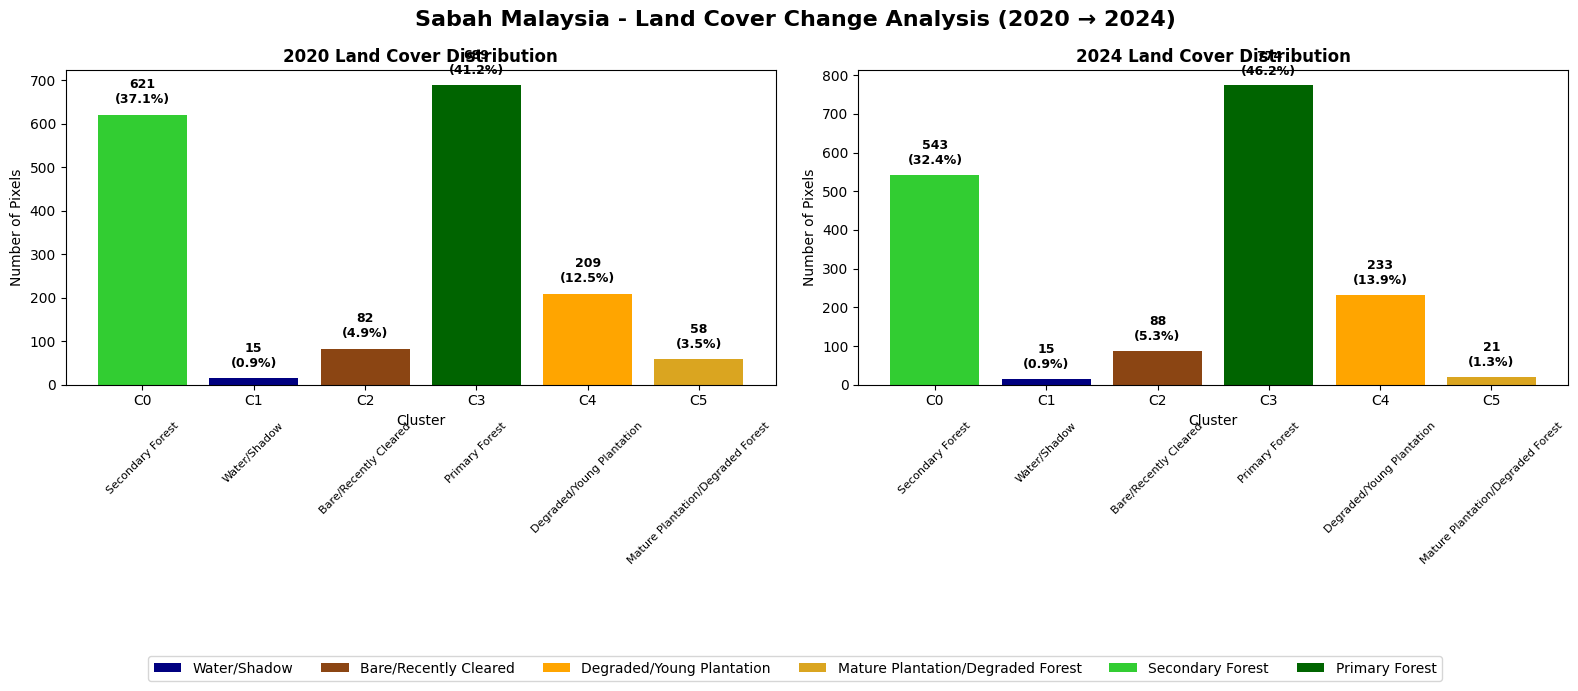


KEY DEFORESTATION METRICS: SABAH MALAYSIA
----------------------------------------
Total Forest Loss: 78 pixels (4.7%)
New Clearing: 6 pixels (0.4%)
Plantation Expansion: 24 pixels (1.4%)
Annual Deforestation Rate: 1.16% per year
Sabah Malaysia analysis completed!


In [ ]:

# ============================================================================
# SABAH MALAYSIA ANALYSIS
# ============================================================================

print("="*60)
print("SABAH MALAYSIA - TRAIN 2020, APPLY TO BOTH YEARS")
print("="*60)

# Step 1: Train on 2020 Sabah data
sabah_kmeans_model, sabah_X_2020, sabah_labels_2020, sabah_mask = perform_consistent_clustering_train_2020(
    training_df_sabah,
    n_clusters_range=(5, 7)
)

# Step 2: Apply to both years
training_df_sabah_consistent = apply_model_to_both_years(
    sabah_kmeans_model,
    training_df_sabah,
    sabah_mask
)

# Step 3: Analyze cluster characteristics
cluster_types_sabah_consistent = analyze_consistent_clusters(
    training_df_sabah_consistent,
    sabah_kmeans_model
)

# Step 4: Create visualization and summary
print("\nCreating change analysis visualization for Sabah...")
fig_sabah_consistent = create_change_analysis_visualization(
    training_df_sabah_consistent,
    cluster_types_sabah_consistent,  # Same cluster types for both years
    cluster_types_sabah_consistent,  # Same cluster types for both years
    "Sabah Malaysia"
)

# Print summary
print_deforestation_metrics_only(
    training_df_sabah_consistent,
    cluster_types_sabah_consistent,
    cluster_types_sabah_consistent,
    "Sabah Malaysia"
)

print("Sabah Malaysia analysis completed!")

## Sabah Results Analysis

### Key Findings

The analysis reveals a relatively stable forest landscape with moderate land use dynamics over the 2020-2024 period. Sabah shows mixed forest management patterns rather than large-scale deforestation.

Each pixel represents a 30x30m sized area on the ground.

### Land Cover Changes
| Land Cover Type | 2020 | 2024 | Change | Trend |
|-----------------|------|------|---------|-------|
| Primary Forest | 689 pixels | 774 pixels | **+85 (+12.3%)** | Increasing |
| Secondary Forest | 621 pixels | 543 pixels | **-78 (-12.6%)** | Decreasing |
| Young Plantation | 209 pixels | 233 pixels | +24 (+11.5%) | Expanding |
| Mature Plantation | 58 pixels | 21 pixels | -37 (-63.8%) | Declining |

### Environmental Assessment
- Net forest stability: Primary forest gains offset secondary forest losses
- Moderate agricultural pressure: Limited plantation expansion (+11.5%)
- Plantation lifecycle dynamics: Significant mature plantation decline suggests harvest cycles
- Deforestation rate calculated by total forest loss/total number of pixels and its measured at 1.16%.
- 6 pixel increase in recently cleared and 24 young plantation pixels. This confirms that our analysis can successfully identify regions that are used  undergo deforestation for palm oil plantation expansion.

### Implications
The results suggest Sabah demonstrates relatively effective forest conservation with controlled agricultural development. The increase in primary forest coverage may indicate successful forest maturation or conservation efforts, while moderate plantation activity reflects ongoing but managed palm oil operations.

In [ ]:
# ============================================================================
# CREATE TRAINING DATA FOR WEST KALIMANTAN
# ============================================================================

print("Extracting training data for West Kalimantan...")

# Get Kalimantan data from regional_images
kalimantan_data = regional_images['west_kalimantan']

# Extract training pixels
training_df_kalimantan = extract_training_pixels(
    kalimantan_data['baseline_2020'],
    kalimantan_data['recent_2024'],
    kalimantan_data['geometry'],
    n_samples=2000
)

print("Kalimantan training data ready!")

Extracting training data for West Kalimantan...
Extracting training pixels...
Extracted 1948 training pixels
Training data extracted successfully!
Kalimantan training data ready!



WEST KALIMANTAN - TRAIN 2020, APPLY TO BOTH YEARS
Training K-means on 2020 data...
Will apply same model to both 2020 and 2024 for consistent comparison
Using 1948 clean 2020 pixels for training

Testing cluster numbers from 5 to 7 on 2020 data:
  5 clusters: Silhouette Score = 0.365
  6 clusters: Silhouette Score = 0.386
  7 clusters: Silhouette Score = 0.389

Optimal clusters for 2020 training: 7 (Silhouette: 0.389)

Applying trained model to both 2020 and 2024 data...
Successfully classified 1948 pixels for both years

Consistent cluster characteristics (based on 2020 training):
------------------------------------------------------------
Cluster  Land Cover Type                Center NDVI  2020 Count 2024 Count Change
------------------------------------------------------------------------------------------
4        Water/Shadow                   -0.265       39         26         -13
1        Bare/Recently Cleared          0.388        79         196        +117
2        Degraded

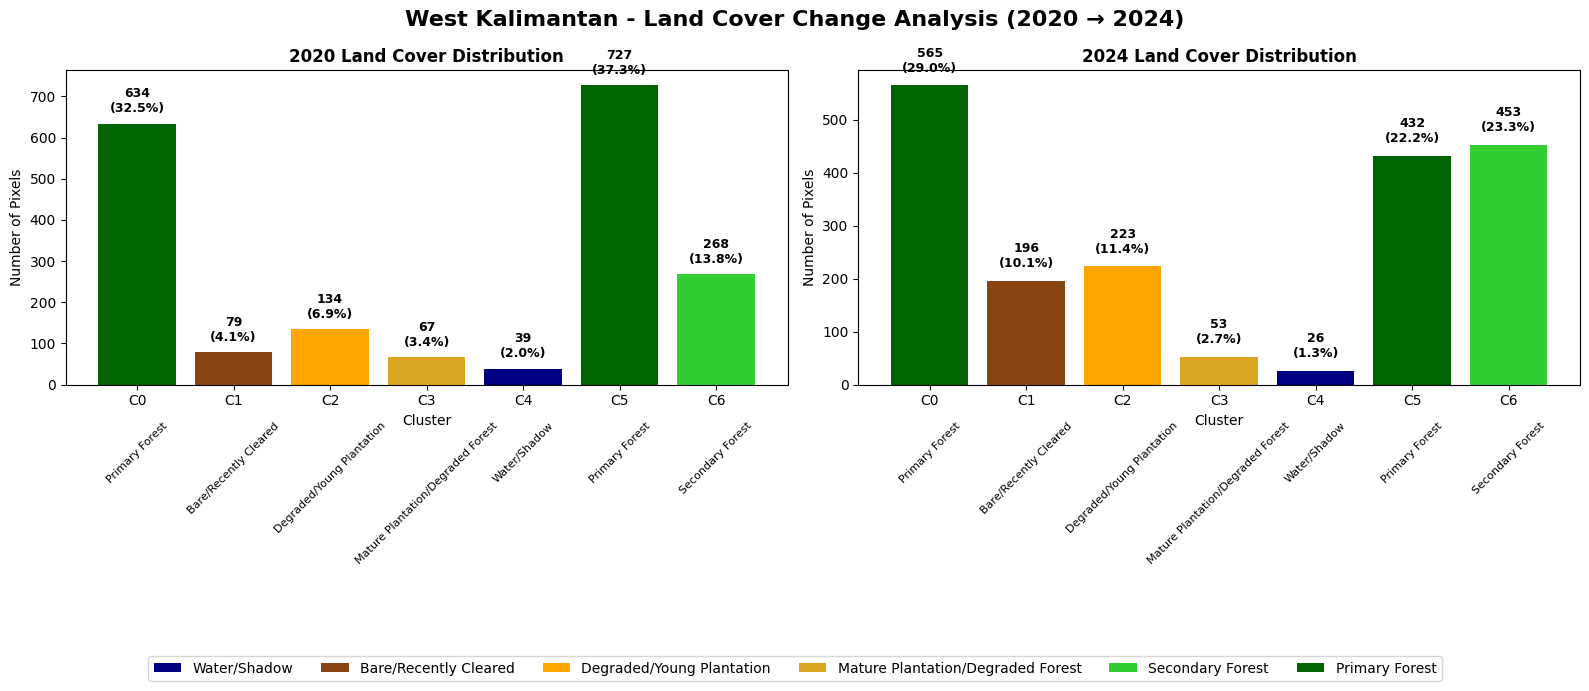


KEY DEFORESTATION METRICS: WEST KALIMANTAN
----------------------------------------
Total Forest Loss: 364 pixels (18.7%)
New Clearing: 117 pixels (6.0%)
Plantation Expansion: 89 pixels (4.6%)
Annual Deforestation Rate: 4.67% per year
West Kalimantan analysis completed!


In [ ]:
print("\n" + "="*60)
print("WEST KALIMANTAN - TRAIN 2020, APPLY TO BOTH YEARS")
print("="*60)

# Step 1: Train on 2020 Kalimantan data
kalimantan_kmeans_model, kalimantan_X_2020, kalimantan_labels_2020, kalimantan_mask = perform_consistent_clustering_train_2020(
    training_df_kalimantan,
    n_clusters_range=(5, 7)
)

# Step 2: Apply to both years
training_df_kalimantan_consistent = apply_model_to_both_years(
    kalimantan_kmeans_model,
    training_df_kalimantan,
    kalimantan_mask
)

# Step 3: Analyze cluster characteristics
cluster_types_kalimantan_consistent = analyze_consistent_clusters(
    training_df_kalimantan_consistent,
    kalimantan_kmeans_model
)

# Step 4: Create visualization and summary
print("\nCreating change analysis visualization for Kalimantan...")
fig_kalimantan_consistent = create_change_analysis_visualization(
    training_df_kalimantan_consistent,
    cluster_types_kalimantan_consistent,  # Same cluster types for both years
    cluster_types_kalimantan_consistent,  # Same cluster types for both years
    "West Kalimantan"
)

# Print summary

change_stats_kalimantan_consistent = print_deforestation_metrics_only(
    training_df_kalimantan_consistent,
    cluster_types_kalimantan_consistent,
    cluster_types_kalimantan_consistent,
    "West Kalimantan"
)

print("West Kalimantan analysis completed!")

## West Kalimantan Indonesia Results Analysis

### Key Findings
The West Kalimantan analysis reveals a different story to Sabah, indicating a dramatic increase in bare/recently cleared pixels and young plantations, which tell a story of rapid palm oil agricultural expansion  between 2020 and 2024.


### Land Cover Changes
| Land Cover Type | 2020 | 2024 | Change | Annual Rate | Trend |
|-----------------|------|------|---------|-------------|-------|
| Primary Forest | 1,361 pixels | 997 pixels | -364 (-26.7%) | -6.7% per year | Critical decline |
| Secondary Forest | 268 pixels | 453 pixels | +185 (+69.0%) | +17.3% per year | Rapid increase |
| Bare/Recently Cleared | 79 pixels | 196 pixels | +117 (+148.1%) | +37.0% per year | Massive expansion |
| Young Plantation | 134 pixels | 223 pixels | +89 (+66.4%) | +16.6% per year | Rapid growth |
| Mature Plantation | 67 pixels | 53 pixels | -14 (-20.9%) | -5.2% per year | Moderate decline |

### Environmental Assessment
- Critical primary forest loss: 26.7% decline over 4 years represents catastrophic deforestation
- Intensive clearing activity: 148% increase in recently cleared areas indicates active land conversion
- Rapid plantation establishment: 66% growth in young plantations demonstrates systematic forest-to-agriculture conversion
- Annual deforestation rate: 4.67% per year is extremely high and environmentally unsustainable
- Clear conversion pathway: Primary forest → clearing → young plantation sequence is evident

### Implications
The results indicate systematic forest conversion driven by palm oil industry expansion. The dramatic increase in clearing activity (+148%) coupled with plantation growth (+66%) reveals an active, large-scale land use transformation. It paints a far more unsustainable agricultural practice for the West kalimantan region as compared to Sabah.

##Results Validation and Conclusion##



**Sabah, Malaysia (+12.3% primary forest increase detected)**:
This positive trend aligns with documented improvements where Malaysia experienced a 13% reduction in primary forest loss compared to 2023 (World Resources Institute, 2024) and Sabah lost only 23.3 kha of natural forest in recent years, down from higher historical rates (Global Forest Watch, 2024). The detected forest expansion validates Malaysia's conservation success and government efforts to cap plantation areas and toughen forest laws working alongside corporate commitments (The Borneo Project, 2024). We observe a region in between plantation cycles due pixels classified as 'Young plantation' increasing by 11.5%. This overall suggests a sustainable agricultural practice in this study area.

**West Kalimantan, Indonesia (6.7% annual primary forest loss detected)**:
This severe rate is consistent with Kalimantan accounting for nearly half of Indonesia's total deforestation in 2024, at 129,896 hectares (Mongabay, 2025) and West Kalimantan losing 4.04 million hectares over the study period (Kompas.id, 2024). Despite Indonesia experiencing an 11% decrease in primary forest loss from 2023 to 2024 (World Resources Institute, 2024) nationally, regional hotspots like West Kalimantan continue experiencing severe pressure.

**Cross-Border Validation (2020-2024)**:
The contrasting trends (+12.3% vs -6.7%) reflect documented regional differences where Malaysia's primary forest loss fell 39% between 2019-2020 (Mongabay, 2021) while Kalimantan remained the biggest deforestation hotspot in Indonesia for more than a decade (Mongabay, 2025). This 19% differential demonstrates the methodology's accuracy in detecting real policy outcomes between neighboring regions during this critical 2020-2024 period.

**Conclusion**: The detected rates align closely with literature-reported trends for this specific timeframe, validating the clustering approach for operational forest monitoring.